## Employee Turnover at TECHCO

Dataset Source: https://www.kaggle.com/datasets/ryanthomasallen/simulated-data-for-ml-paper

#### Import Necessary Libraries

In [1]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

#### Show Library Versions

In [2]:
n = 18

print(f"Language/Library".rjust(n-2), '|', 'Version')
print('-' * (n-2), '|', '--------')
print("Python :".rjust(n), sys.version[0:6])
print("NumPy :".rjust(n), np.__version__)
print("Pandas :".rjust(n), pd.__version__)
print("Sklearn :".rjust(n), sklearn.__version__)
print("Imblearn :".rjust(n), imblearn.__version__)
print("Seaborn :".rjust(n), sns.__version__)

Language/Library | Version
---------------- | --------
          Python : 3.9.12
           NumPy : 1.23.5
          Pandas : 2.0.0
         Sklearn : 1.2.2
        Imblearn : 0.10.1
         Seaborn : 0.12.2


#### Ingest Dataset

In [3]:
parent_dir = "/Users/briandunn/Desktop/current projects/Employee Turnover at TECHCO"

col_names = ["tenure",
             "training_score", 
             "logical_score", 
             "verbal_score",
             "avg_literacy", 
             "location_age", 
             "drive_length",
             "similar_language", 
             "is_male", 
             "emp_id",
             "label"]

dtypes = {"tenure": np.uint8,
             "training_score": np.float64, 
             "logical_score": np.int16,
             "verbal_score": np.int16,
             "avg_literacy": np.float64, 
             "location_age": np.uint8, 
             "drive_length": np.float64, 
             "similar_language": np.float64, 
             "is_male": np.uint8,
             "emp_id": np.int16,
             "label": str,}

data_file_location = os.path.join(parent_dir, "simulated_TECHCO_data.csv")

data = pd.read_csv(data_file_location,
                   names=col_names, 
                   dtype=dtypes,
                   engine='c',
                   header=0)

# Only keep the last sample for each 
data = data.sort_values(["emp_id", "tenure"])\
    .drop_duplicates(subset = ['emp_id'], keep ='last')\
    .reset_index(drop=True)

# Drop emp_id (it is the ID of this dataset)
data = data.drop(columns=['emp_id'])

data

,tenure,training_score,logical_score,verbal_score,avg_literacy,location_age,drive_length,similar_language,is_male,label
0,39,4.840446,5,2,81.05207,6,1.635494,24.11053,1,Stayed
1,34,4.355449,0,8,93.72386,3,0.234684,96.08640,1,Stayed
2,37,4.416302,3,2,66.49519,6,0.673065,100.00000,1,Stayed
3,34,4.995522,11,3,87.05980,13,0.232718,93.20673,1,Stayed
4,33,4.531571,1,0,77.78675,24,2.333878,23.03190,0,Stayed
...,...,...,...,...,...,...,...,...,...,...
1186,34,4.895838,1,3,80.50422,9,0.514864,100.00000,0,Stayed
1187,39,4.503906,0,0,56.55196,12,2.422109,37.59651,1,Left
1188,29,4.945488,6,7,59.76929,27,2.265522,32.94450,0,Left
1189,6,2.829304,7,5,66.10549,10,1.346729,15.10681,0,Left


#### More Dataset Information

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191 entries, 0 to 1190
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            1191 non-null   uint8  
 1   training_score    1191 non-null   float64
 2   logical_score     1191 non-null   int16  
 3   verbal_score      1191 non-null   int16  
 4   avg_literacy      1191 non-null   float64
 5   location_age      1191 non-null   uint8  
 6   drive_length      1191 non-null   float64
 7   similar_language  1191 non-null   float64
 8   is_male           1191 non-null   uint8  
 9   label             1191 non-null   object 
dtypes: float64(4), int16(2), object(1), uint8(3)
memory usage: 54.8+ KB


#### Remove Outliers

In [5]:
# Remove outliers using the 'IQR * 1.5' rule
def remove_outliers(df: pd.DataFrame, 
                    feature: str
                    ) -> pd.DataFrame:
    """
    This function uses the 1.5 times Interquartile 
    Range (IQR) methodology to remove outliers 
    from dataset based on a single (specified) 
    input feature. It returns the resulting 
    dataframe.
    """
    
    assert (df[feature].dtype != 'float' or df[feature].dtype != 'int'), \
        "Please make sure to pass only 'int' or 'float' values only."
    
    q1, q3 = np.percentile(df[feature], [25,75])
    iqr = q3-q1
    ul = q3 + (iqr * 1.5)
    ll = q1 - (iqr * 1.5)
    neo_data = df[(df[feature].values > ll) & (df[feature].values < ul)]
    return neo_data

continuous_numerical_features = ["training_score", 
                                 "avg_literacy", 
                                 "drive_length", 
                                 "similar_language"]

for cnf in continuous_numerical_features:
    data = remove_outliers(data, cnf)

data

,tenure,training_score,logical_score,verbal_score,avg_literacy,location_age,drive_length,similar_language,is_male,label
0,39,4.840446,5,2,81.05207,6,1.635494,24.11053,1,Stayed
1,34,4.355449,0,8,93.72386,3,0.234684,96.08640,1,Stayed
2,37,4.416302,3,2,66.49519,6,0.673065,100.00000,1,Stayed
3,34,4.995522,11,3,87.05980,13,0.232718,93.20673,1,Stayed
4,33,4.531571,1,0,77.78675,24,2.333878,23.03190,0,Stayed
...,...,...,...,...,...,...,...,...,...,...
1185,36,4.952652,12,12,67.51026,6,0.102095,12.52201,0,Stayed
1186,34,4.895838,1,3,80.50422,9,0.514864,100.00000,0,Stayed
1187,39,4.503906,0,0,56.55196,12,2.422109,37.59651,1,Left
1188,29,4.945488,6,7,59.76929,27,2.265522,32.94450,0,Left


### Exploratory Data Analysis

#### Descriptive Statistics

In [6]:
data.describe()

,tenure,training_score,logical_score,verbal_score,avg_literacy,location_age,drive_length,similar_language,is_male
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,30.182230,4.500232,4.406165,4.636446,75.941935,15.336355,0.821627,59.181391,0.563010
std,9.798624,0.393278,3.920725,4.529117,9.294562,7.934865,0.753563,35.209803,0.496239
min,1.000000,3.215111,-5.000000,-7.000000,49.354540,2.000000,0.000000,1.250000,0.000000
25%,27.000000,4.245547,1.000000,1.000000,68.936500,9.000000,0.184115,27.170575,0.000000
50%,34.000000,4.566437,4.000000,4.000000,77.615080,11.000000,0.580323,48.774620,1.000000
75%,37.000000,4.826582,8.000000,8.000000,83.108675,24.000000,1.277199,98.817410,1.000000
max,39.000000,5.110679,12.000000,17.000000,97.357410,28.000000,2.951231,100.000000,1.000000


#### Class Distribution

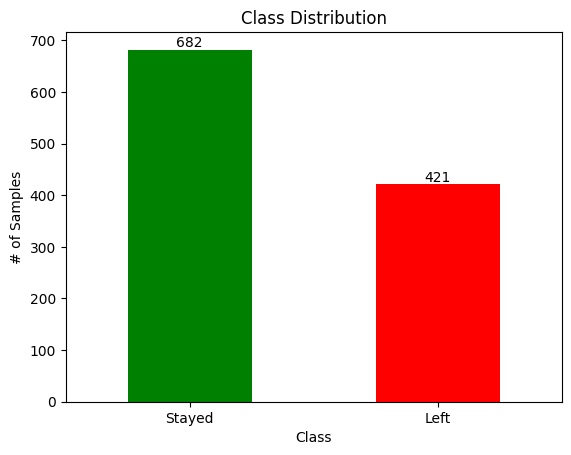

In [7]:
ax = data['label'].value_counts().plot.bar(rot=0, color=["green", "red"])
plt.suptitle('')
plt.title('Class Distribution')
plt.ylabel('# of Samples')
plt.xlabel('Class')

ax.bar_label(ax.containers[0])

plt.show()

#### Dataset Visualization: Gender (is_male)

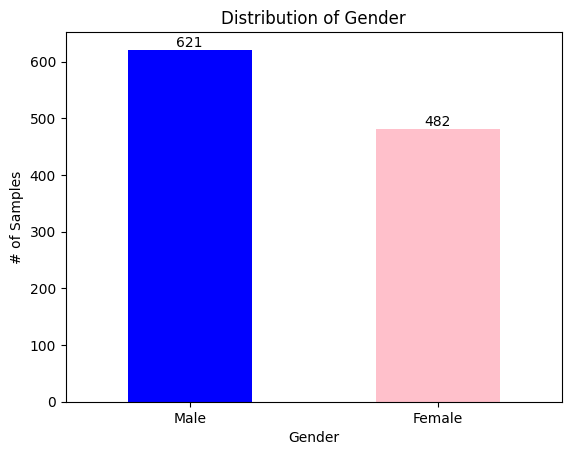

In [8]:
id2label = {0: "Female", 1: "Male"}
label2id = {"Female": 0, "Male": 1}

data['is_male'] = data['is_male'].replace(id2label)

ax = data['is_male'].value_counts().plot.bar(rot=0, 
                                             color=["blue", "pink"])
plt.suptitle('')
plt.title('Distribution of Gender')
plt.ylabel('# of Samples')
plt.xlabel('Gender')

ax.bar_label(ax.containers[0])

plt.show()

data['is_male'] = data['is_male'].replace(label2id)

#### Create Function to Visualize Features (Histograms)

In [9]:
def histogram_visual(feature_to_visualize: pd.Series,
                     num_of_bins: int,
                     plot_title: str,
                     x_label: str,
                     x_start: float = -1.0,
                     y_label: str = "# of Samples",
                     ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - x_start: To force the x-axis of the visual to start at 
    a specified value instead of the automatically generated 
    value, assign the float value here. Otherwise, the 
    autogenerated start value will be used.
    - y_label: The string label value for the y label.
    
    Output:
    - A histogram.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(x_start) != 'float', \
        "The x_start value must be a float value."
    
    ax = feature_to_visualize.hist(grid=False, 
                                   bins=num_of_bins, 
                                   figsize=(18, 8))
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    if x_start != -1:
        plt.xlim([0, (max(feature_to_visualize) + (1/num_of_bins))])

    plt.show()

#### Dataset Visualization: Tenure

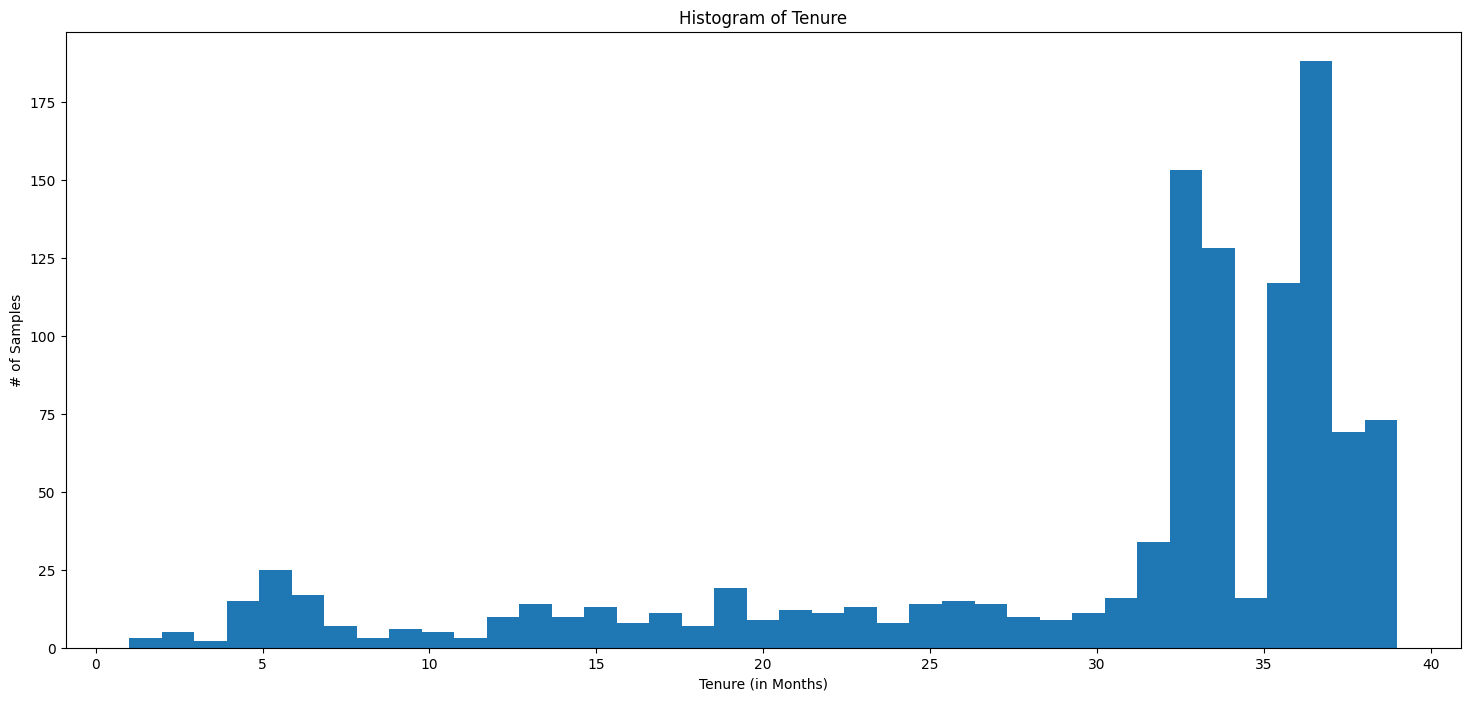

The tenure range was 1 to 39 months.


In [10]:
histogram_visual(data['tenure'],
                 num_of_bins=39,
                 plot_title="Histogram of Tenure",
                 x_label="Tenure (in Months)")


print(f"The tenure range was {min(data['tenure'])} to" + 
      f" {max(data['tenure'])} months.")

#### Dataset Visualization: Training Score

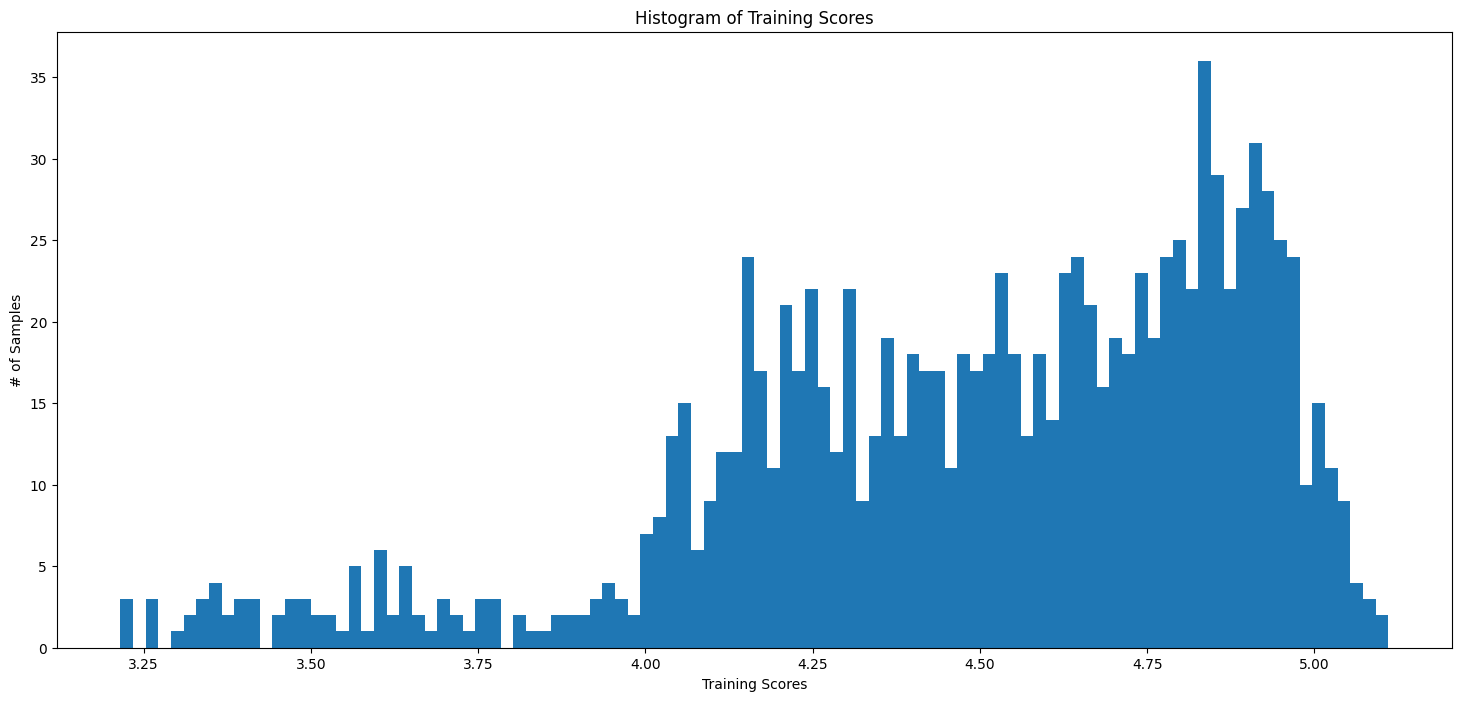

The training score range was 3.215111 to 5.110679.


In [11]:
histogram_visual(data['training_score'],
                 num_of_bins=100,
                 plot_title="Histogram of Training Scores",
                 x_label="Training Scores")

print(f"The training score range was {min(data['training_score'])} to" + 
      f" {max(data['training_score'])}.")

#### Dataset Visualization: Logical Score

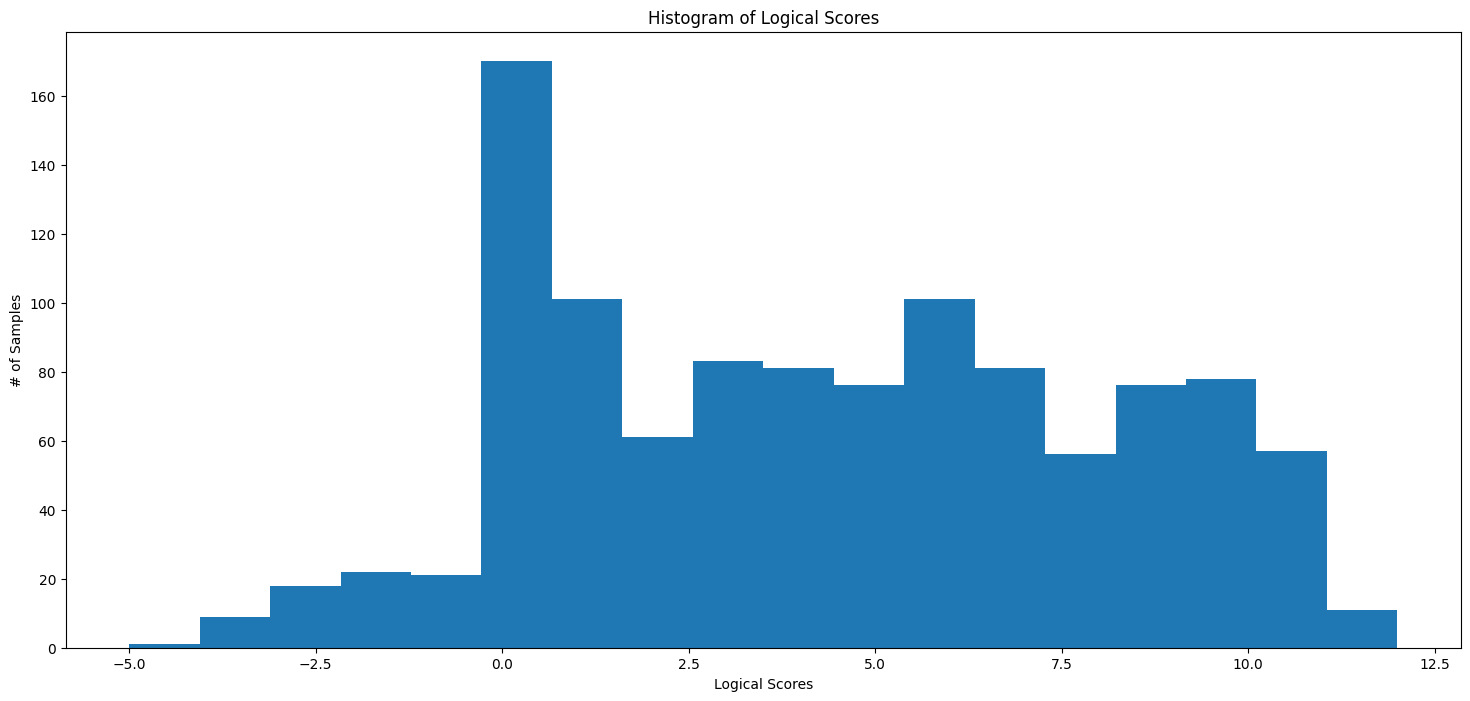

The logical score range was -5 to 12.


In [12]:
histogram_visual(data['logical_score'],
                 num_of_bins=18,
                 plot_title="Histogram of Logical Scores",
                 x_label="Logical Scores")

print(f"The logical score range was {min(data['logical_score'])} to" + 
      f" {max(data['logical_score'])}.")

#### Dataset Visualization: Verbal Score

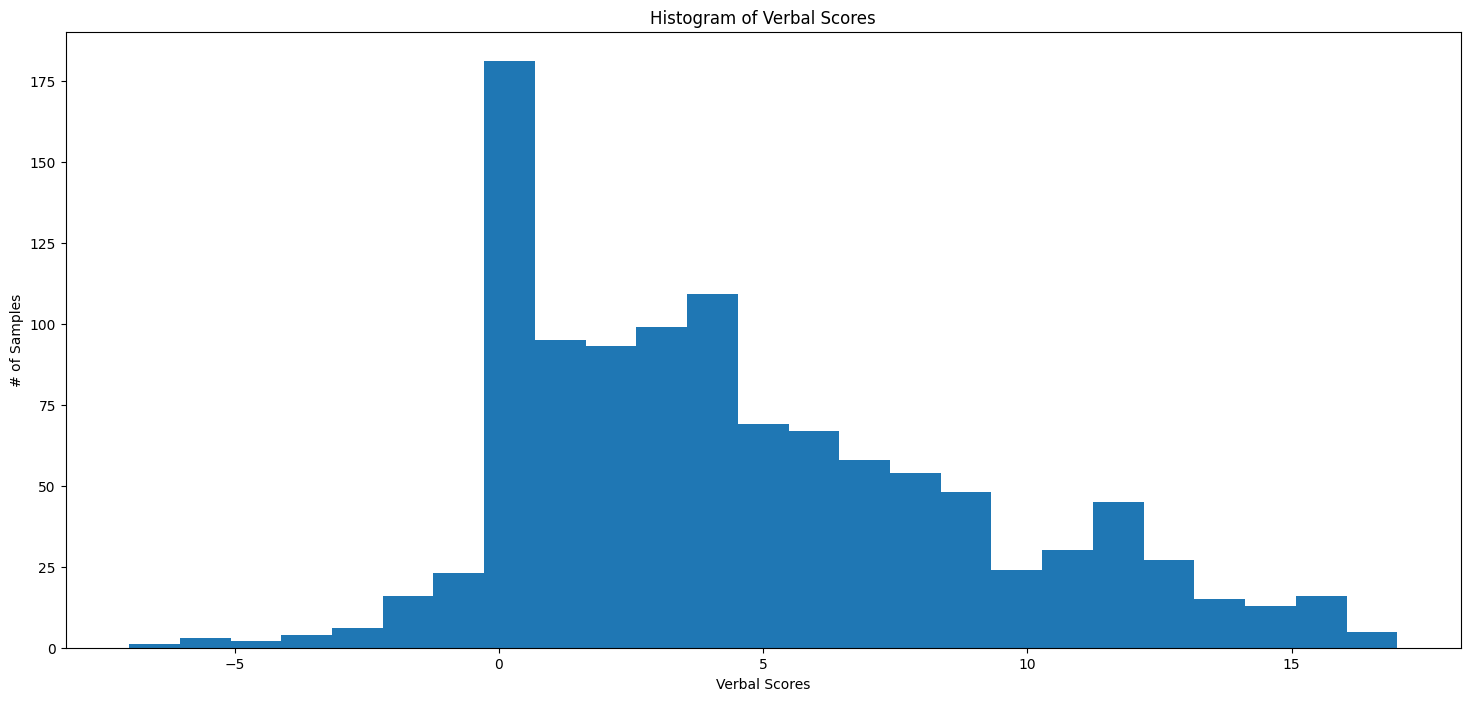

The verbal score range was -7 to 17.


In [13]:
histogram_visual(data['verbal_score'],
                 num_of_bins=25,
                 plot_title="Histogram of Verbal Scores",
                 x_label="Verbal Scores")

print(f"The verbal score range was {min(data['verbal_score'])} to" + 
      f" {max(data['verbal_score'])}.")

#### Dataset Visualization: Average Literacy

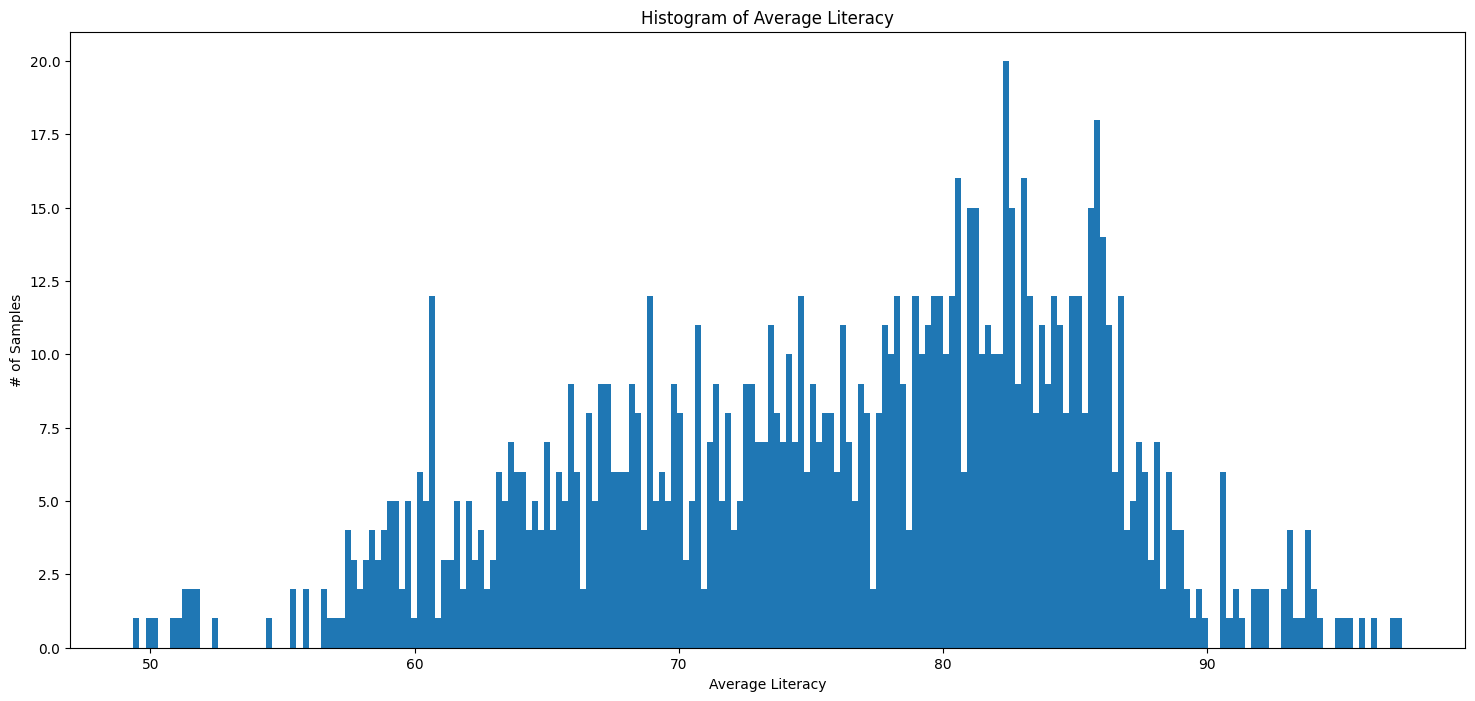

The range for Average Literacy in the employee's home region  was 49.35454 to 97.35741.


In [14]:
histogram_visual(data['avg_literacy'],
                 num_of_bins=210,
                 plot_title="Histogram of Average Literacy",
                 x_label="Average Literacy")

print(f"The range for Average Literacy in the employee's "
      f"home region  was {min(data['avg_literacy'])} to" + 
      f" {max(data['avg_literacy'])}.")

#### Dataset Visualization: Location Age

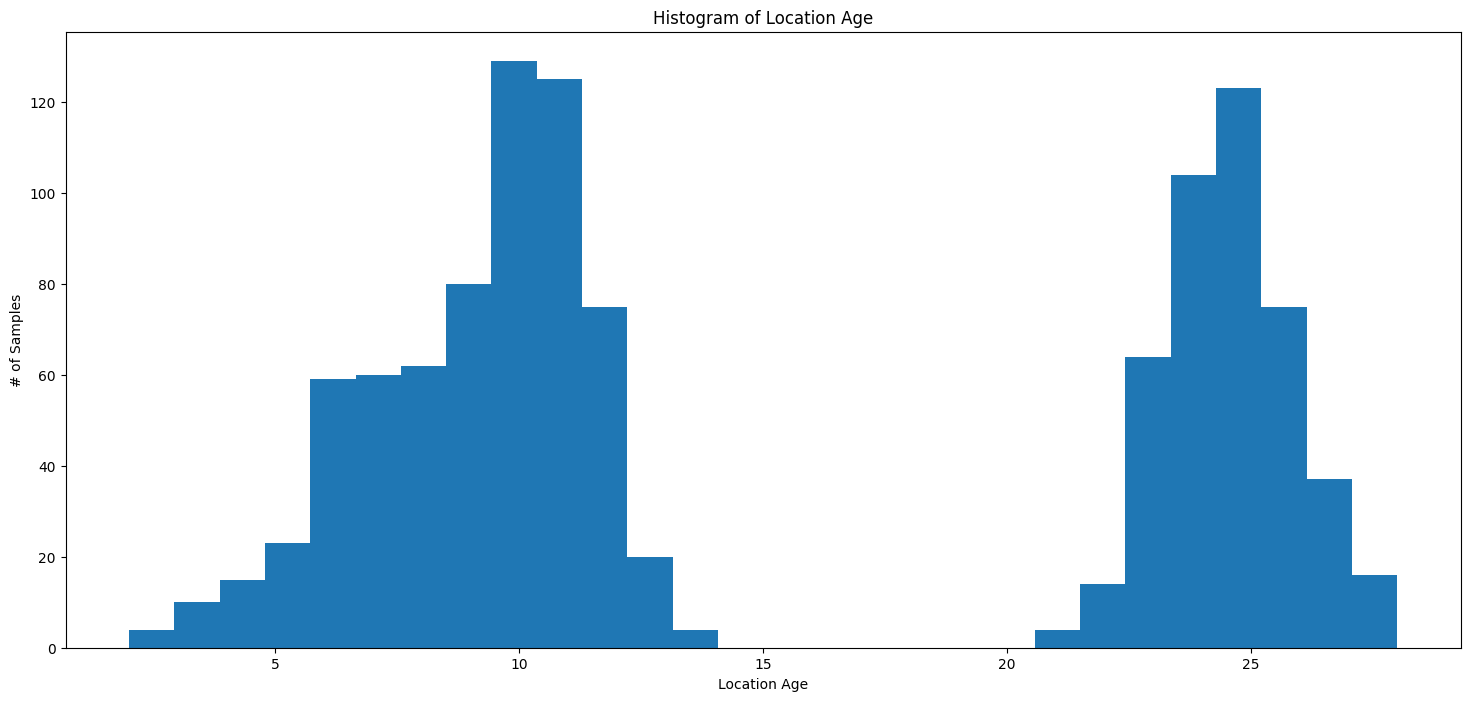

The range for age of the production center that employees are assigned to is 2 to 28.

*Note: unit type for the Location Age feature was not specified.


In [15]:
histogram_visual(data['location_age'],
                 num_of_bins=28,
                 plot_title="Histogram of Location Age",
                 x_label="Location Age")

print(f"The range for age of the production center "
      f"that employees are assigned to is " +
      f"{min(data['location_age'])} to {max(data['location_age'])}.")

print("\n*Note: unit type for the Location Age feature was not specified.")

#### Dataset Visualization: Drive Length

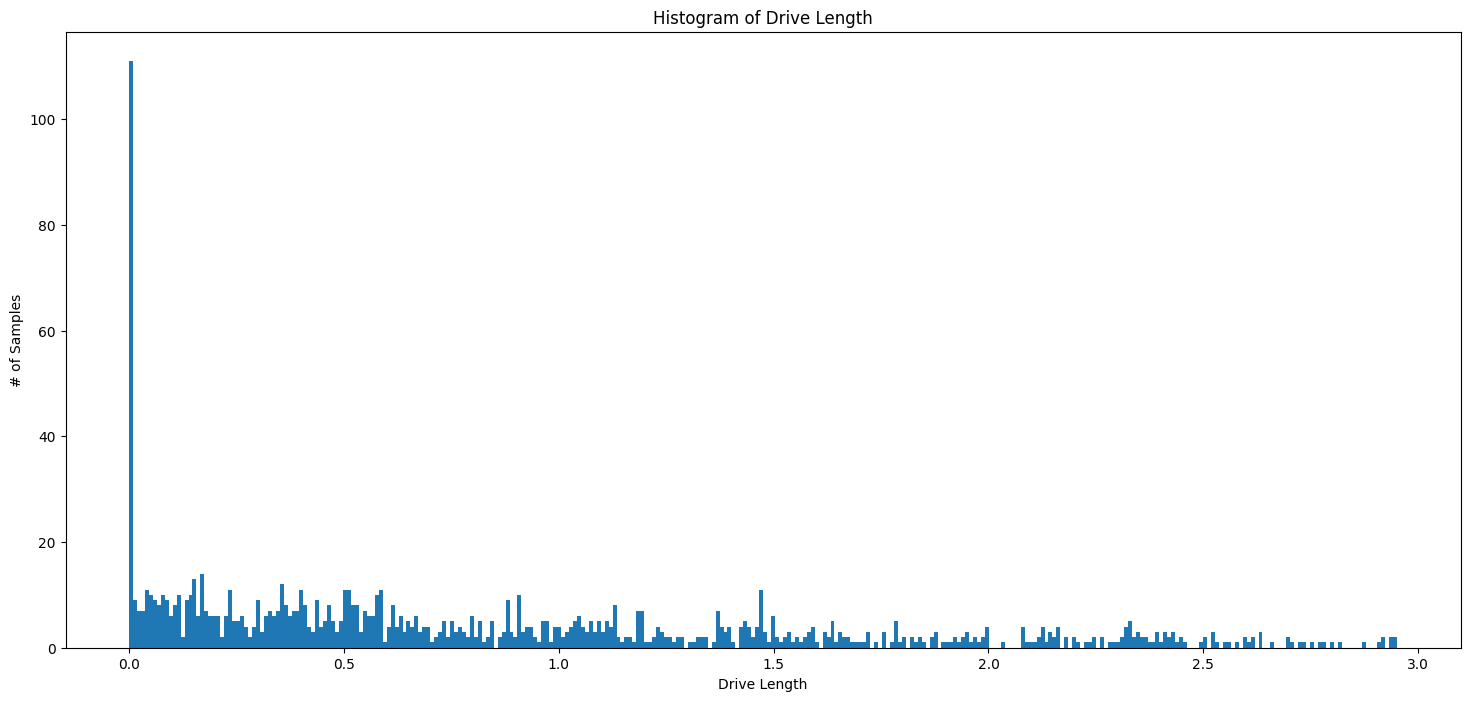

The drive length for employees to get to work from home is 0.0 to 2.951231.

*Note: unit type for the Drive Length feature was not specified.


In [16]:
histogram_visual(data['drive_length'],
                 num_of_bins=320,
                 plot_title="Histogram of Drive Length",
                 x_label="Drive Length")

print(f"The drive length for employees to get to work from home is " + 
      f"{min(data['drive_length'])} to {max(data['drive_length'])}.")

print("\n*Note: unit type for the Drive Length feature was not specified.")

#### Dataset Visualization: Similar Language (to Local Geographical Region)

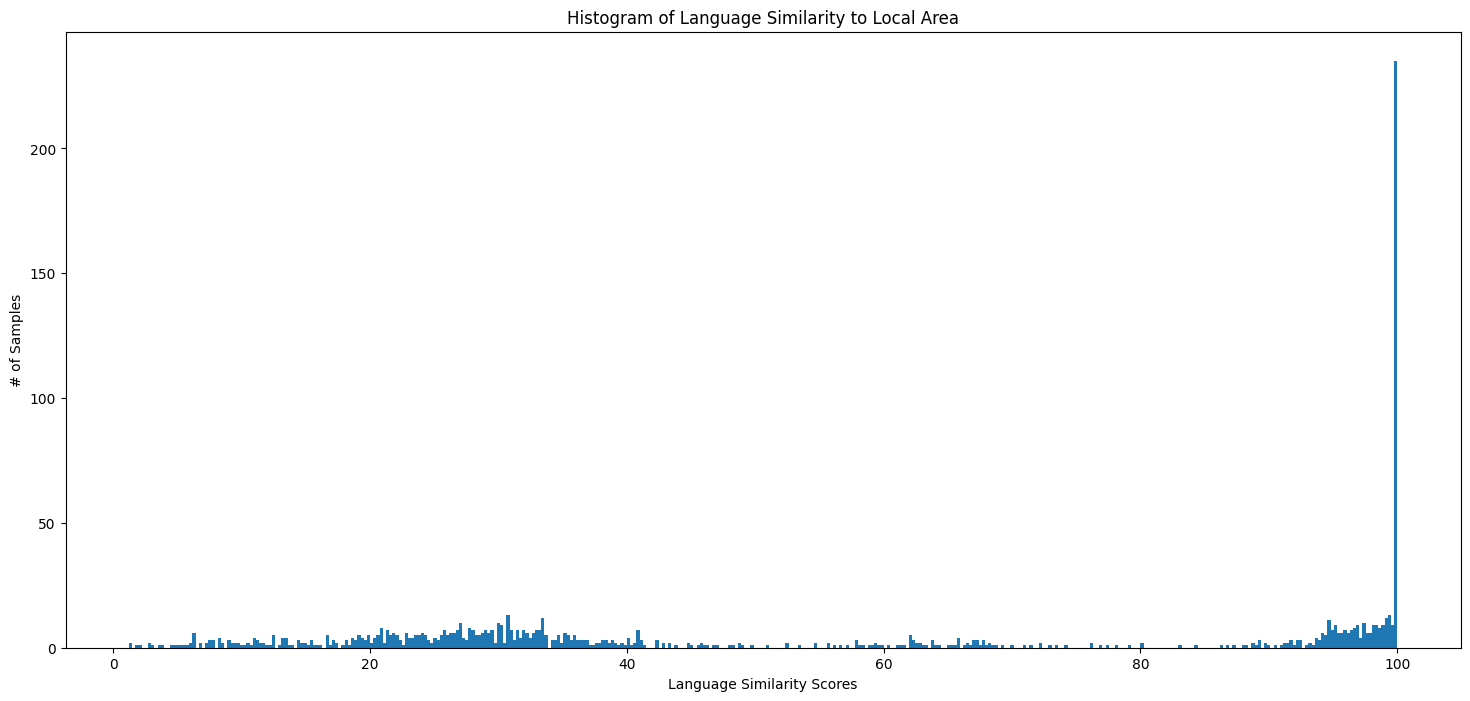

The language similarity for employees to that of the their hometown 0.0 to 2.951231.


In [17]:
histogram_visual(data['similar_language'],
                 num_of_bins=400,
                 plot_title="Histogram of Language Similarity to Local Area",
                 x_label="Language Similarity Scores")

print("The language similarity for employees to that of " + 
      f"the their hometown {min(data['drive_length'])}" + 
      f" to {max(data['drive_length'])}.")

#### Finish Preprocessing Dataset

In [18]:
data['label'] = data['label'].replace({"Stayed": 0, "Left": 1})

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1103 entries, 0 to 1190
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            1103 non-null   uint8  
 1   training_score    1103 non-null   float64
 2   logical_score     1103 non-null   int16  
 3   verbal_score      1103 non-null   int16  
 4   avg_literacy      1103 non-null   float64
 5   location_age      1103 non-null   uint8  
 6   drive_length      1103 non-null   float64
 7   similar_language  1103 non-null   float64
 8   is_male           1103 non-null   int64  
 9   label             1103 non-null   int64  
dtypes: float64(4), int16(2), int64(2), uint8(2)
memory usage: 66.8 KB


#### Correlation Matrix

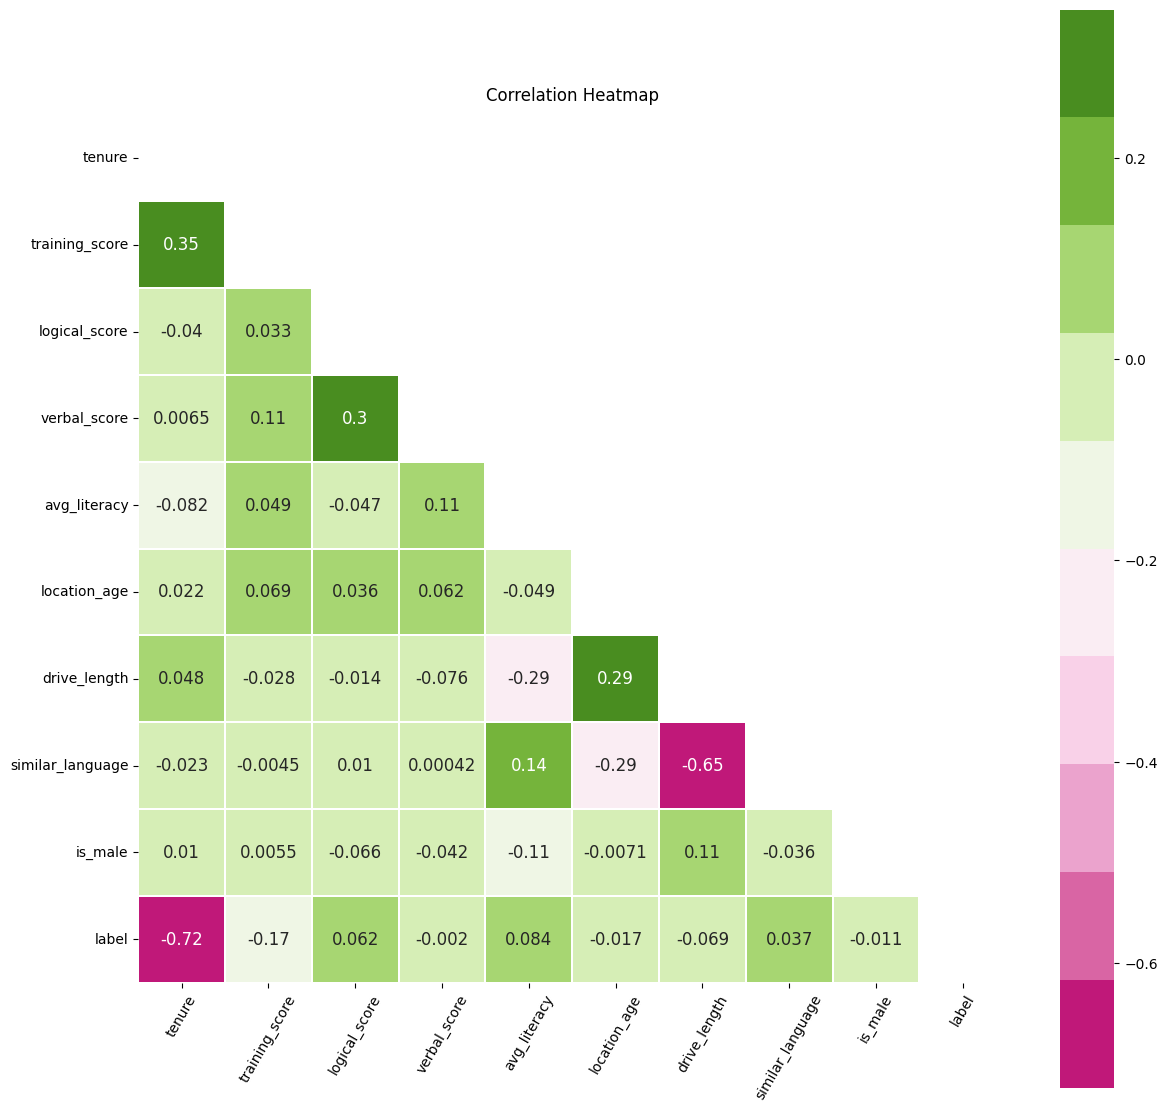

In [19]:
plt.figure(figsize=(14, 14))

lower_triangle = np.triu(data.corr())

corr_matrix = sns.heatmap(data.corr(), 
                          annot=True, 
                          cmap=sns.color_palette("PiYG", 10),
                          mask=lower_triangle,
                          square=True,
                          linewidths=0.25,
                          annot_kws={"size":12})

corr_matrix.set_title("Correlation Heatmap", pad=10)
corr_matrix.set_xticklabels(corr_matrix.get_xticklabels(), rotation=60)
plt.show()

#### Split Dataset into Training & Testing Datasets

In [20]:
y = data['label']
X = data.drop(columns=['label'])

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

#### Check Results of Dataset Split

In [21]:
print(f"Training Inputs Dataset Shape: {X_train.shape}")
print(f"Training Outputs Dataset Shape: {y_train.shape}")
print(f"Testing Inputs Dataset Shape: {X_test.shape}")
print(f"Testing Outputs Dataset Shape: {y_test.shape}")

Training Inputs Dataset Shape: (882, 9)
Training Outputs Dataset Shape: (882,)
Testing Inputs Dataset Shape: (221, 9)
Testing Outputs Dataset Shape: (221,)


#### Create Column Transformer

In [22]:
ct = ColumnTransformer(
    [
        ('OrdEncoder', OrdinalEncoder(), ["logical_score", "tenure", "verbal_score"]), 
        ('OHEncoder', OneHotEncoder(), ["is_male", "location_age"])
    ], 
    remainder='passthrough')

#### Instantiate SMOTE for Data Imbalance

In [23]:
smote = SMOTE(random_state=42, sampling_strategy='all')

smote

SMOTE(random_state=42, sampling_strategy='all')

#### Define Algorithm

In [24]:
rfc = RandomForestClassifier(random_state=42)

#### Create Pipeline

In [25]:
rfc_pipeline = Pipeline(
    [
        ("ct", ct),
        ("imblearn", smote),
        ("classifier", rfc)
    ]
)

#### Fit Model

In [26]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Generate Predictions

In [27]:
y_pred_cv = cross_val_predict(rfc, 
                              X_test, 
                              y_test, 
                              cv=10)

#### Confusion Matrix

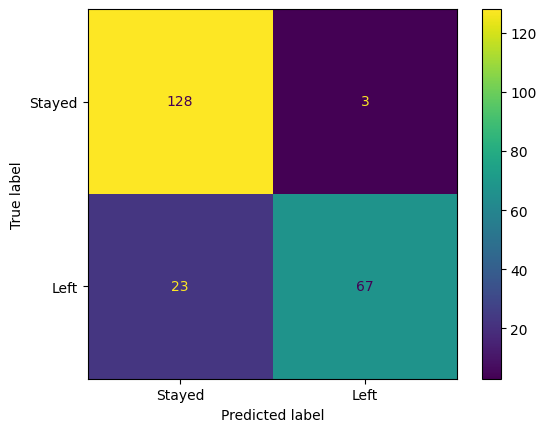

In [28]:
cm = confusion_matrix(y_test, y_pred_cv)

display_cm = ConfusionMatrixDisplay(cm, display_labels=["Stayed", "Left"])

display_cm.plot()
plt.show()

#### Classification Report

In [29]:
print(classification_report(y_test, y_pred_cv, target_names=["Stayed", "Left"]))

              precision    recall  f1-score   support

      Stayed       0.85      0.98      0.91       131
        Left       0.96      0.74      0.84        90

    accuracy                           0.88       221
   macro avg       0.90      0.86      0.87       221
weighted avg       0.89      0.88      0.88       221



#### Create DataFrame with Features & Their Importances'

In [30]:
importances = []

for fi in range(len(rfc.feature_names_in_)):
    next_sub_list = [rfc.feature_names_in_[fi], rfc.feature_importances_[fi]]
    importances.append(next_sub_list) 
    next_sub_list = []

feature_importances = pd.DataFrame(importances, 
                                   columns=['Feature', 'Importance'])

feature_importances

,Feature,Importance
0,tenure,0.661171
1,training_score,0.085504
2,logical_score,0.033995
3,verbal_score,0.031749
4,avg_literacy,0.055626
5,location_age,0.030633
6,drive_length,0.055234
7,similar_language,0.039737
8,is_male,0.006352


#### Display Feature Importances

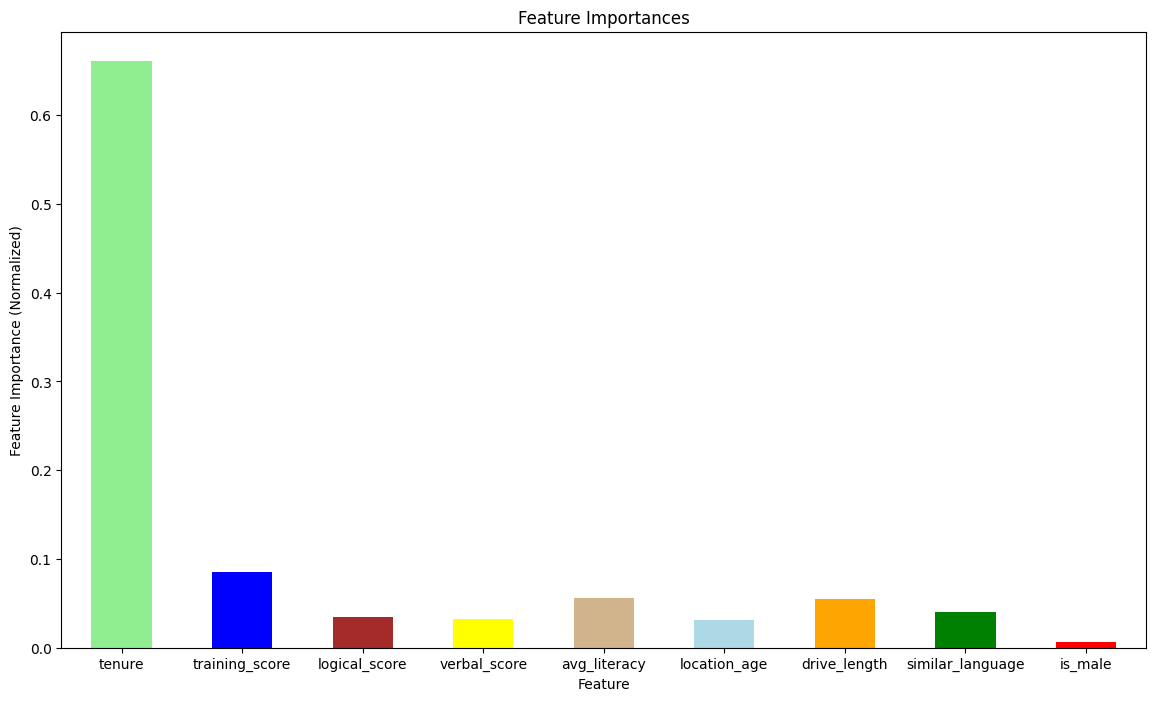

In [32]:
labels = [x for x in feature_importances['Feature']]

ax = feature_importances.plot.bar(x='Feature', 
                                  y='Importance', 
                                  figsize=(14,8),
                                  rot=0, 
                                  legend=False,
                                  color=["lightgreen", 
                                         "blue", 
                                         "brown", 
                                         "yellow",
                                         "tan", 
                                         "lightblue", 
                                         "orange",
                                         "green", 
                                         "red"])

plt.suptitle('')
plt.title('Feature Importances')
plt.ylabel('Feature Importance (Normalized)')
plt.xlabel('Feature')

plt.show()

### Notes & Other Takeaways From This Project
****
- The results are pretty good. 
- The next step I would do is to break this problem into two problems. I would split the dataset based on the 'tenure' feature, using the mean tenure (rounded to the nearest whole month value) as the divider.
****